# Data processing

In [111]:
%%capture
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
base_path='/kaggle/input/asl-fingerspelling/'

In [112]:
import warnings
warnings.filterwarnings("ignore","NumPy version", category=UserWarning)
import numpy as np 
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
from scipy.stats import skew, kurtosis


In [113]:
DEBUG = True

In [114]:
train_path=f'{base_path}/train.csv'
train = pd.read_csv(train_path).head(10) if DEBUG else pd.read_csv(file_path)
train

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road
5,train_landmarks/5414471.parquet,5414471,1817141095,38,www.freem.ne.jp
6,train_landmarks/5414471.parquet,5414471,1817169529,70,https://jsi.is/hukuoka
7,train_landmarks/5414471.parquet,5414471,1817171518,202,239613 stolze street
8,train_landmarks/5414471.parquet,5414471,1817195757,136,242-197-6202
9,train_landmarks/5414471.parquet,5414471,1817216847,93,271097 bayshore boulevard


In [115]:
train['phrase_char'] = train['phrase'].apply(tuple)
train['phrase_char_len'] = train['phrase_char'].apply(len)

train_sequence_id = train.set_index('sequence_id')

train.head()

,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25


In [116]:
with open(base_path+'character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)

CHAR2ORD_df=pd.Series(CHAR2ORD).to_frame('Ordinal Encoding')
print(type(CHAR2ORD),type(CHAR2ORD_df))

N_UNIQUE_CHARACTERS = len(CHAR2ORD)
print(f'CHAR2ORD: {CHAR2ORD}\nN_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}')

def encode_phrase(phrase):
    # .get(char, -1): if the char doesn't exist in dict, return -1.
    return [CHAR2ORD.get(char, -1) for char in phrase]

train['ordinal_encoding'] = train['phrase'].apply(encode_phrase)

train.head()


<class 'dict'> <class 'pandas.core.frame.DataFrame'>
CHAR2ORD: {' ': 0, '!': 1, '#': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '?': 28, '@': 29, '[': 30, '_': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'j': 41, 'k': 42, 'l': 43, 'm': 44, 'n': 45, 'o': 46, 'p': 47, 'q': 48, 'r': 49, 's': 50, 't': 51, 'u': 52, 'v': 53, 'w': 54, 'x': 55, 'y': 56, 'z': 57, '~': 58}
N_UNIQUE_CHARACTERS: 59


,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,ordinal_encoding
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]"
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15,"[50, 34, 32, 43, 36, 50, 14, 42, 52, 39, 32, 5..."
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19,"[16, 18, 23, 18, 0, 54, 40, 43, 43, 40, 32, 44..."
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17,"[24, 23, 23, 0, 37, 49, 32, 45, 42, 43, 40, 45..."
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25,"[21, 24, 17, 15, 0, 45, 46, 49, 51, 39, 36, 32..."


In [117]:
# Add complete file path to train
def get_file_path(path):
    return f'{base_path}{path}'

train['file_path'] = train['path'].apply(get_file_path)
train.head()

,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,ordinal_encoding,file_path
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15,"[50, 34, 32, 43, 36, 50, 14, 42, 52, 39, 32, 5...",/kaggle/input/asl-fingerspelling/train_landmar...
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19,"[16, 18, 23, 18, 0, 54, 40, 43, 43, 40, 32, 44...",/kaggle/input/asl-fingerspelling/train_landmar...
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17,"[24, 23, 23, 0, 37, 49, 32, 45, 42, 43, 40, 45...",/kaggle/input/asl-fingerspelling/train_landmar...
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25,"[21, 24, 17, 15, 0, 45, 46, 49, 51, 39, 36, 32...",/kaggle/input/asl-fingerspelling/train_landmar...


In [118]:
# Add phrase_type col
def get_phrase_type(phrase):
    if re.match(r'^[\d+-]+$', phrase):
        return 'phone_number'
    elif any([substr in phrase for substr in ['www', '.', '/']]) and ' ' not in phrase:
        return 'url'
    else:
        return 'address'
    
train['phrase_type'] = train['phrase'].apply(get_phrase_type)
train.head()

,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,ordinal_encoding,file_path,phrase_type
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15,"[50, 34, 32, 43, 36, 50, 14, 42, 52, 39, 32, 5...",/kaggle/input/asl-fingerspelling/train_landmar...,url
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19,"[16, 18, 23, 18, 0, 54, 40, 43, 43, 40, 32, 44...",/kaggle/input/asl-fingerspelling/train_landmar...,address
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17,"[24, 23, 23, 0, 37, 49, 32, 45, 42, 43, 40, 45...",/kaggle/input/asl-fingerspelling/train_landmar...,address
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25,"[21, 24, 17, 15, 0, 45, 46, 49, 51, 39, 36, 32...",/kaggle/input/asl-fingerspelling/train_landmar...,address


# Deal with landmarks files

In [119]:
def get_col_with_NaN(dataframe):
    has_nan = dataframe.isna().any()
    columns_with_nan = has_nan[has_nan].index.tolist()
    print(len(list(dataframe.iterrows())),',',len(columns_with_nan))
    print("Columns with NaN values:", columns_with_nan)
    
#get_col_with_NaN(pd.read_parquet(train['file_path'][0]))

In [120]:
%%time
def process_landmarks(file_path,sequence_id, debug=False):
    landmarks = pd.read_parquet(file_path)
    landmarks = landmarks.loc[landmarks.index == seq_id]
#     print(landmarks)
#     return
    
    hand_columns_without_z = [col for col in landmarks.columns if ('left_hand' in col or 'right_hand' in col) and not col.startswith('z_')]
    landmarks = landmarks[['frame']+hand_columns_without_z]

    landmarks['sequence_id'] = sequence_id

    # Deal with NaN  (*problem: not sure which way to fill NaN is better)
    coordinate_columns = [col for col in landmarks.columns if col.startswith(('x_', 'y_'))]
    landmarks.loc[:, coordinate_columns] = landmarks[coordinate_columns].fillna(0.0)
    
    # Others..unfinished....
    # ...

    return landmarks


#processed_landmarks_list = [process_landmarks(file_path, debug=DEBUG) for file_path in tqdm(train['file_path'])]
processed_landmarks_list = []
for file_path, seq_id in tqdm(zip(train['file_path'], train['sequence_id'])):
    processed_landmarks = process_landmarks(file_path, seq_id, debug=DEBUG)
    processed_landmarks_list.append(processed_landmarks)
    
all_processed_landmarks = pd.concat(processed_landmarks_list, ignore_index=True)

0it [00:00, ?it/s]

CPU times: user 38.6 s, sys: 21.7 s, total: 1min
Wall time: 34.6 s


In [121]:
all_processed_landmarks.head()

,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,...,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,sequence_id
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621,1816796431
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1816796431
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1816796431
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.493427,0.667076,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930,1816796431
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1816796431


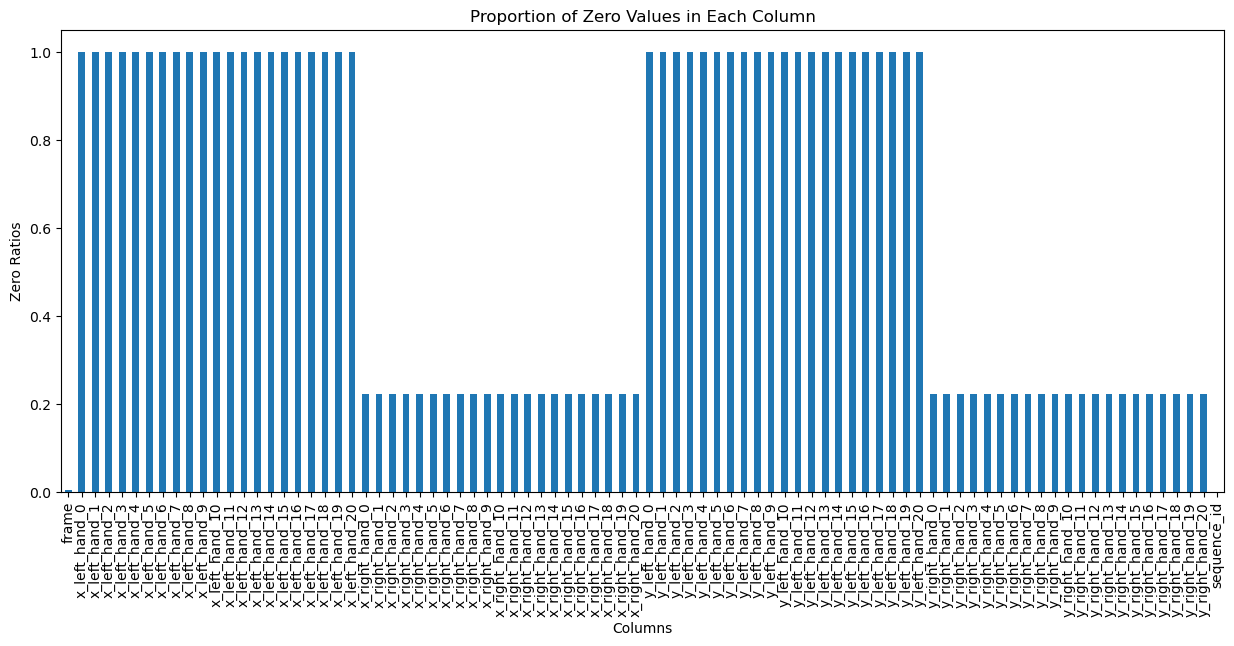

In [122]:
zero_ratios = (all_processed_landmarks == 0).mean()

plt.figure(figsize=(15, 6))
zero_ratios.plot(kind='bar')

plt.xlabel('Columns')
plt.ylabel('Zero Ratios')
plt.title('Proportion of Zero Values in Each Column')
plt.show()


In [123]:
# Get all kind of body part in landmarks
columns = all_processed_landmarks.columns

parts = set()

for col in columns:
    if '_' in col:
        part_name = '_'.join(col.split('_')[1:-1])
        if len(part_name)>0:
            parts.add(part_name)

parts_list = list(parts)
print(parts_list)

['left_hand', 'right_hand']


In [124]:
# %%time
# final_coordinates_list = []

# for row_index, frame in tqdm(all_processed_landmarks.iterrows()):
# #     if DEBUG and len(final_coordinates_list) >= 1000:
# #         break
#     for part_name in parts_list:
#         max_index = max(int(col.split('_')[-1]) for col in columns if f'x_{part_name}_' in col)
#         for index in range(max_index + 1):
#             temp_coordinates = {
#                 'sequence_id': int(frame['sequence_id']),
#                 'frame': int(frame['frame']),
#                 'part': part_name,
#                 'index': index,
#                 'x': frame[f'x_{part_name}_{index}'],
#                 'y': frame[f'y_{part_name}_{index}'],
#                 'z': frame[f'z_{part_name}_{index}'],
#             }
#             final_coordinates_list.append(temp_coordinates)

# new_df = pd.DataFrame(final_coordinates_list)

In [125]:
# # Just want to try--
# # Set MultiIndex
# new_df.set_index(['part', 'index'], inplace=True)

# print(new_df.loc[('right_hand', 20)])
# print(new_df.loc[('pose')].head())
# new_df.tail()

# new_df.reset_index(inplace=True)

In [126]:
# merged_df = pd.merge(train, new_df, on='sequence_id', how='left')

# #merged_df.query("part=='pose'")
# merged_df

# Merge Train and Landmarks

In [127]:
merged_df = pd.merge(train, all_processed_landmarks, on='sequence_id', how='left')

#print(', '.join(merged_df.columns))
merged_df.info()
merged_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 1955
Data columns (total 95 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   path              1956 non-null   object 
 1   file_id           1956 non-null   int64  
 2   sequence_id       1956 non-null   int64  
 3   participant_id    1956 non-null   int64  
 4   phrase            1956 non-null   object 
 5   phrase_char       1956 non-null   object 
 6   phrase_char_len   1956 non-null   int64  
 7   ordinal_encoding  1956 non-null   object 
 8   file_path         1956 non-null   object 
 9   phrase_type       1956 non-null   object 
 10  frame             1956 non-null   int16  
 11  x_left_hand_0     1956 non-null   float32
 12  x_left_hand_1     1956 non-null   float32
 13  x_left_hand_2     1956 non-null   float32
 14  x_left_hand_3     1956 non-null   float32
 15  x_left_hand_4     1956 non-null   float32
 16  x_left_hand_5     1956 non-null   float32


,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,ordinal_encoding,file_path,phrase_type,...,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.490615,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621
1,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.528952,0.493427,0.667076,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930
4,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,train_landmarks/5414471.parquet,5414471,1817216847,93,271097 bayshore boulevard,"(2, 7, 1, 0, 9, 7, , b, a, y, s, h, o, r, e, ...",25,"[17, 22, 16, 15, 24, 22, 0, 33, 32, 56, 50, 39...",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.585567,0.592299,0.659575,0.606061,0.604364,0.611468,0.678657,0.628700,0.612541,0.606417
1952,train_landmarks/5414471.parquet,5414471,1817216847,93,271097 bayshore boulevard,"(2, 7, 1, 0, 9, 7, , b, a, y, s, h, o, r, e, ...",25,"[17, 22, 16, 15, 24, 22, 0, 33, 32, 56, 50, 39...",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.587370,0.594575,0.658194,0.606481,0.605387,0.612707,0.677004,0.628976,0.613097,0.606258
1953,train_landmarks/5414471.parquet,5414471,1817216847,93,271097 bayshore boulevard,"(2, 7, 1, 0, 9, 7, , b, a, y, s, h, o, r, e, ...",25,"[17, 22, 16, 15, 24, 22, 0, 33, 32, 56, 50, 39...",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.590698,0.601197,0.658238,0.606409,0.607284,0.616498,0.678761,0.630763,0.614214,0.607441
1954,train_landmarks/5414471.parquet,5414471,1817216847,93,271097 bayshore boulevard,"(2, 7, 1, 0, 9, 7, , b, a, y, s, h, o, r, e, ...",25,"[17, 22, 16, 15, 24, 22, 0, 33, 32, 56, 50, 39...",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [128]:
get_col_with_NaN(merged_df)

1956 , 0
Columns with NaN values: []


In [129]:
# Feature cols
features = merged_df.drop(columns=[ 'ordinal_encoding','path','file_id','sequence_id','participant_id','phrase','phrase_char','file_path'])

# Label cols
labels = merged_df['ordinal_encoding']


features.shape,labels.shape
features

,phrase_char_len,phrase_type,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,...,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20
0,12,address,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.490615,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621
1,12,address,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,12,address,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,12,address,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.528952,0.493427,0.667076,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930
4,12,address,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,25,address,448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.585567,0.592299,0.659575,0.606061,0.604364,0.611468,0.678657,0.628700,0.612541,0.606417
1952,25,address,449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.587370,0.594575,0.658194,0.606481,0.605387,0.612707,0.677004,0.628976,0.613097,0.606258
1953,25,address,450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.590698,0.601197,0.658238,0.606409,0.607284,0.616498,0.678761,0.630763,0.614214,0.607441
1954,25,address,451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [130]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

phrase_type = features['phrase_type'].values.reshape(-1, 1)


phrase_type_onehot = encoder.fit_transform(phrase_type)
phrase_type_onehot_df = pd.DataFrame(phrase_type_onehot, columns=encoder.get_feature_names_out(['phrase_type']))

features = features.drop(columns=['phrase_type'])
features = pd.concat([features.reset_index(drop=True), phrase_type_onehot_df], axis=1)

#phrase_type_onehot_df
features.head()


,phrase_char_len,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,...,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,phrase_type_address,phrase_type_phone_number,phrase_type_url
0,12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621,1.0,0.0,0.0
1,12,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
2,12,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
3,12,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930,1.0,0.0,0.0
4,12,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0


# Train model

In [107]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed
from sklearn.model_selection import train_test_split
from keras.metrics import SparseCategoricalAccuracy

In [108]:
def get_landmarks_by_sequence_id(sequence_id, file_path_column):
    file_path = file_path_column.loc[sequence_id]
    landmarks = pd.read_parquet(file_path)
    return landmarks.loc[sequence_id].values

In [109]:
%%time
max_seq_len = max(len(seq) for seq in train['ordinal_encoding'])
 
file_path_column = train.set_index('sequence_id')['file_path']

X = []
y = []

for seq_id, target_sequence in zip(tqdm(train['sequence_id']), train['ordinal_encoding']):
    landmarks_sequence = get_landmarks_by_sequence_id(seq_id, file_path_column)
    
    # 检查样本是否具有所需的形状，例如 (n, 1630)
    if len(landmarks_sequence.shape) != 2 or landmarks_sequence.shape[1] != 1630:
        print(f"Skipping sequence {seq_id} due to incorrect shape {landmarks_sequence.shape}")
        continue  # 跳过这个样本
    
    X.append(landmarks_sequence)
    y.append(np.array(target_sequence).reshape(-1, 1))

X = pad_sequences(X, maxlen=max_seq_len, padding='post', dtype='float32') 


y = pad_sequences(y, maxlen=max_seq_len, padding='post') 

#print(X,y)
 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

 
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(None, X_train.shape[2])))
model.add(TimeDistributed(Dense(N_UNIQUE_CHARACTERS, activation='softmax')))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=[SparseCategoricalAccuracy()])

 
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

sample_index = 0
sample_X = X_val[sample_index].reshape(1, *X_val[sample_index].shape) 
predicted_probs = model.predict(sample_X)
predicted_sequence = np.argmax(predicted_probs, axis=-1).flatten()  


  0%|          | 0/10 [00:00<?, ?it/s]


KeyboardInterrupt



In [110]:
sample_index = 0
sample_X = X_val[sample_index].reshape(1, *X_val[sample_index].shape) 
predicted_probs = model.predict(sample_X)
predicted_sequence = np.argmax(predicted_probs, axis=-1).flatten() 
predicted_sequence

NameError: name 'X_val' is not defined

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

In [ ]:
print(X_train.shape)
print(X_val.shape)